# Exploring DANDI:001275 - Primate Mental Navigation Dataset

**NOTE: This notebook was AI-generated using dandi-notebook-gen and has not been fully verified. Please be cautious when interpreting the code or results.**

This notebook demonstrates how to access and analyze data from a primate mental navigation task where subjects performed mental navigation between landmarks on a linear track.

## Required Packages

Before running this notebook, ensure you have the following packages installed:
- pynwb
- lindi
- numpy
- matplotlib
- seaborn

In [1]:
import pynwb
import lindi
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Loading the Dataset

First, let's use the DANDI API to list all assets in the dataset:

In [2]:
from dandi.dandiapi import DandiAPIClient
client = DandiAPIClient()
dandiset = client.get_dandiset("001275")
assets = list(dandiset.get_assets())

# Print basic information about available files
print("Available NWB files:")
for asset in assets:
    print(f"- {asset.path}")

Available NWB files:
- sub-mahler/sub-mahler_ses-03122021_behavior+ecephys.nwb
- sub-mahler/sub-mahler_ses-03172021_behavior+ecephys.nwb
- sub-mahler/sub-mahler_ses-03152021_behavior+ecephys.nwb
- sub-mahler/sub-mahler_ses-03182021_behavior+ecephys.nwb
- sub-mahler/sub-mahler_ses-03192021_behavior+ecephys.nwb
- sub-mahler/sub-mahler_ses-03122021_ecephys.nwb
- sub-mahler/sub-mahler_ses-03172021_ecephys.nwb
- sub-mahler/sub-mahler_ses-03152021_ecephys.nwb
- sub-mahler/sub-mahler_ses-03192021_ecephys.nwb
- sub-mahler/sub-mahler_ses-03182021_ecephys.nwb
- sub-amadeus/sub-amadeus_ses-06242019_behavior+ecephys.nwb
- sub-amadeus/sub-amadeus_ses-01042020_behavior+ecephys.nwb
- sub-amadeus/sub-amadeus_ses-06302020_behavior+ecephys.nwb
- sub-amadeus/sub-amadeus_ses-07032020_behavior+ecephys.nwb
- sub-amadeus/sub-amadeus_ses-07082020_behavior+ecephys.nwb
- sub-amadeus/sub-amadeus_ses-06242019_ecephys.nwb
- sub-amadeus/sub-amadeus_ses-01042020_ecephys.nwb
- sub-amadeus/sub-amadeus_ses-06302020_ece

For this analysis, we'll work with one behavior+ecephys file. This file contains both behavioral data and neural recordings from the task.

In [3]:
# Load the NWB file
f = lindi.LindiH5pyFile.from_lindi_file("https://lindi.neurosift.org/dandi/dandisets/001275/assets/b0bbeb4c-5e0d-4050-a993-798173797d94/nwb.lindi.json")
nwb = pynwb.NWBHDF5IO(file=f, mode='r').read()

# Display basic session information
print("Session Information:")
print(f"Subject ID: {nwb.subject.subject_id}")
print(f"Session Date: {nwb.session_start_time}")
print(f"Task Description: {nwb.session_description}")

/opt/conda/lib/python3.11/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


Session Information:
Subject ID: amadeus
Session Date: 2020-01-04 00:00:00-05:00
Task Description: Data from macaque performing mental navigation task. Subject is presented with a start and a target landmark, sampled from a linear map of 6 landmarks on a screen. After a delay, the subject is then cued with a go signal to navigate from start to target landmark with a joystick. Subject should respond by deflecting the joystick in the right direction and holding it until the subject thinks it has arrived at the target landmark. The visual drift or intervening landmarks are all occluded from view making the task a purely mental navigation.


## Behavioral Data Analysis

The task involves mental navigation between landmarks on a linear track. Subjects are presented with start and target landmarks, and after a delay, they must use a joystick to navigate to the target landmark without visual feedback.

Let's analyze different aspects of behavioral performance:

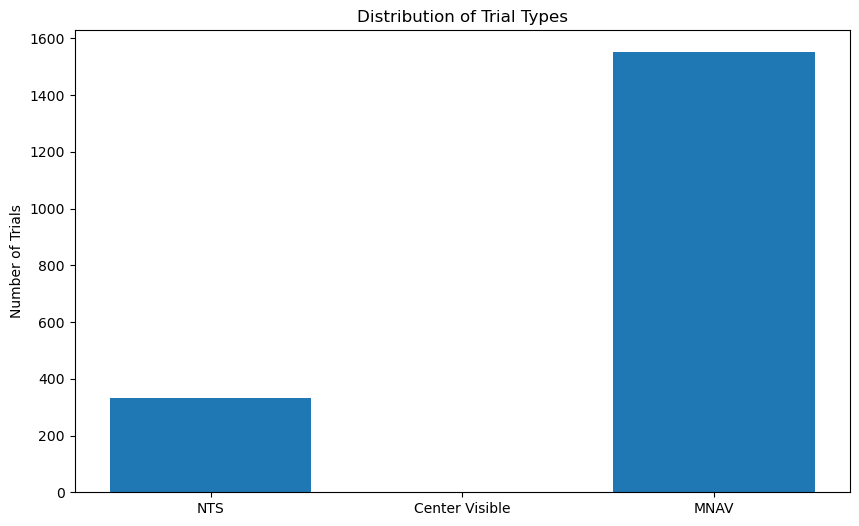

/opt/conda/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


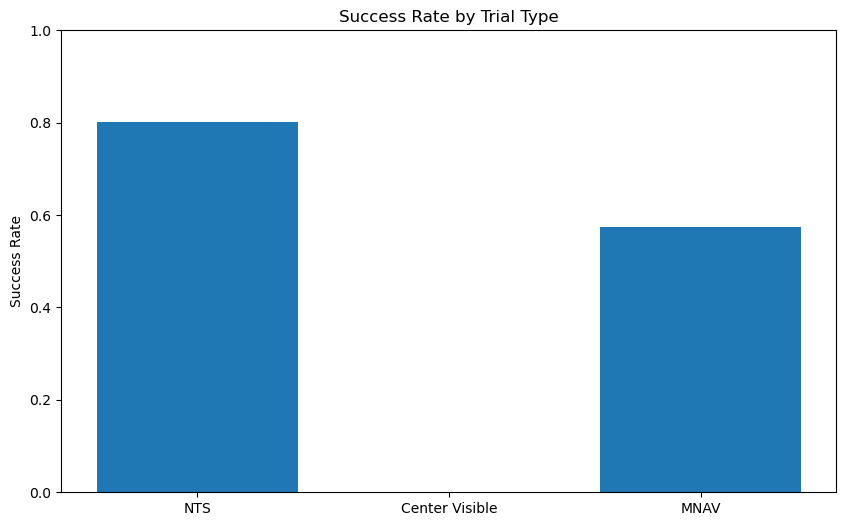

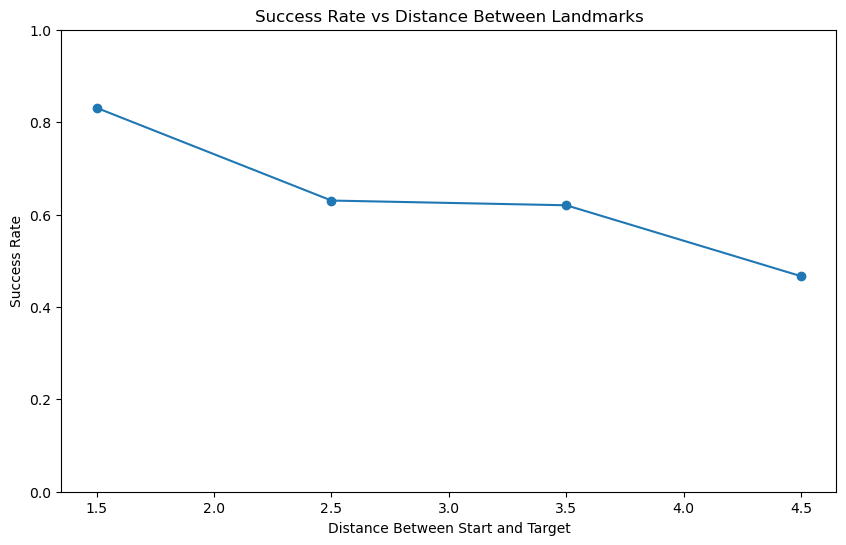

In [4]:
# Get trials data
trials = nwb.intervals["trials"]
trial_types = trials["trial_type"][:]  # 1=NTS (visible), 3=MNAV (occluded)
success = trials["succ"][:]
rt = trials["rt"][:]
start_pos = trials["curr"][:]
target_pos = trials["target"][:]
distances = np.abs(target_pos - start_pos)

# Plot trial type distribution
plt.figure(figsize=(10, 6))
trial_type_counts = np.bincount(trial_types.astype(int))[1:]
plt.bar(['NTS', 'Center Visible', 'MNAV'], trial_type_counts)
plt.title('Distribution of Trial Types')
plt.ylabel('Number of Trials')
plt.show()

# Plot success rates by trial type
plt.figure(figsize=(10, 6))
success_by_type = [np.mean(success[trial_types == i]) for i in [1, 2, 3]]
plt.bar(['NTS', 'Center Visible', 'MNAV'], success_by_type)
plt.title('Success Rate by Trial Type')
plt.ylabel('Success Rate')
plt.ylim(0, 1)
plt.show()

# Plot success rate vs distance
plt.figure(figsize=(10, 6))
dist_bins = np.linspace(0, np.max(distances), 6)
dist_centers = (dist_bins[1:] + dist_bins[:-1]) / 2
success_by_dist = []
for i in range(len(dist_bins)-1):
    mask = (distances >= dist_bins[i]) & (distances < dist_bins[i+1])
    success_by_dist.append(np.mean(success[mask]))

plt.plot(dist_centers, success_by_dist, 'o-')
plt.title('Success Rate vs Distance Between Landmarks')
plt.xlabel('Distance Between Start and Target')
plt.ylabel('Success Rate')
plt.ylim(0, 1)
plt.show()

### Key Behavioral Findings:

1. Trial Types: The dataset contains mostly MNAV (mental navigation) trials where the track was fully occluded, with fewer NTS trials where the track was visible.
2. Success Rates: Performance was better in NTS trials (~80% success) compared to MNAV trials (~58% success).
3. Distance Effect: Success rates decreased as the distance between start and target landmarks increased, suggesting the task becomes more challenging with longer mental navigation distances.

## Neural Data Analysis

The dataset includes neural recordings from electrodes in the posterior parietal cortex. Let's examine the neural data:

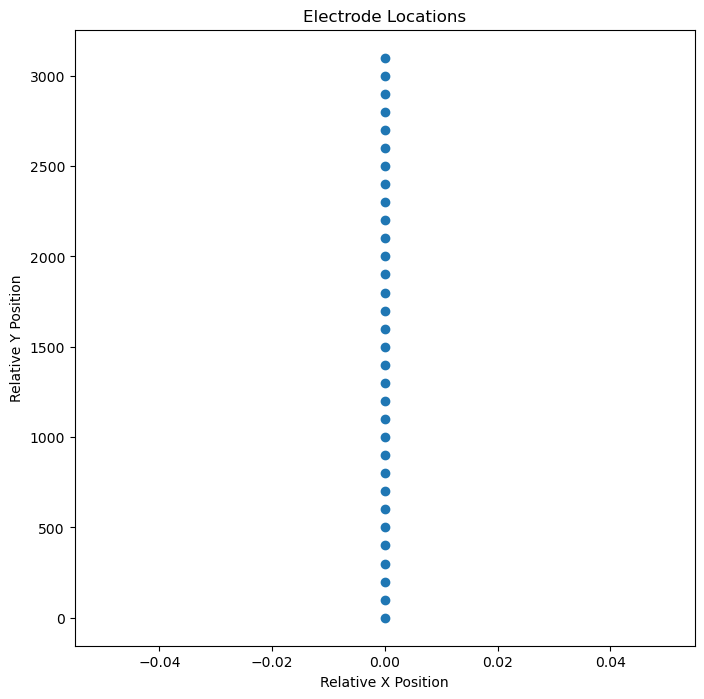

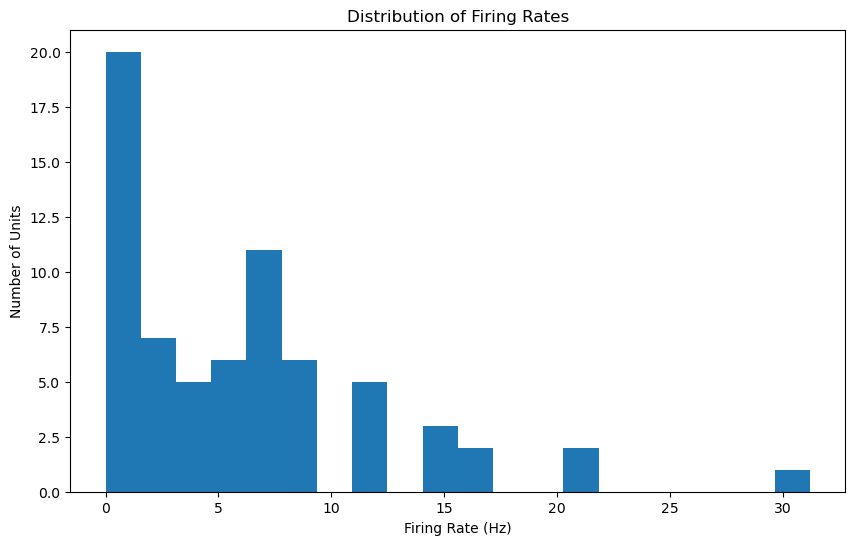

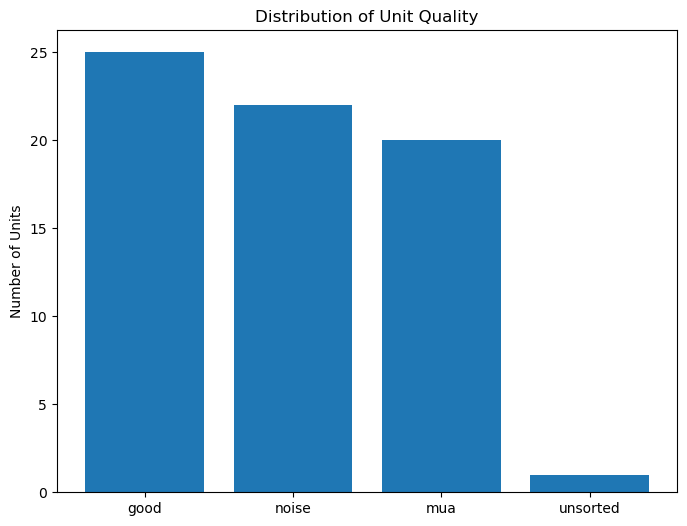

In [5]:
# Get neural data
units = nwb.processing["ecephys"]["units"]
electrodes = nwb.electrodes

# Plot electrode locations
plt.figure(figsize=(8, 8))
x_pos = electrodes["rel_x"].data[:]
y_pos = electrodes["rel_y"].data[:]
plt.scatter(x_pos, y_pos)
plt.title('Electrode Locations')
plt.xlabel('Relative X Position')
plt.ylabel('Relative Y Position')
plt.show()

# Plot firing rate distribution
firing_rates = units["fr"].data[:]
plt.figure(figsize=(10, 6))
plt.hist(firing_rates, bins=20)
plt.title('Distribution of Firing Rates')
plt.xlabel('Firing Rate (Hz)')
plt.ylabel('Number of Units')
plt.show()

# Plot unit quality distribution
quality_counts = {}
for q in units["quality"].data[:]:
    if q in quality_counts:
        quality_counts[q] += 1
    else:
        quality_counts[q] = 1

plt.figure(figsize=(8, 6))
plt.bar(quality_counts.keys(), quality_counts.values())
plt.title('Distribution of Unit Quality')
plt.ylabel('Number of Units')
plt.show()

### Neural Data Characteristics:

1. Recording Configuration:
   - Linear electrode array spanning ~3000 μm in depth
   - 32 recording channels

2. Unit Properties:
   - 68 isolated units
   - Firing rates predominantly below 10 Hz
   - Mix of unit qualities: ~25 good units, ~22 noise, ~20 multi-unit activity (MUA)

## Example: Analyzing Neural Activity Around Task Events

Let's examine neural activity around the go cue:

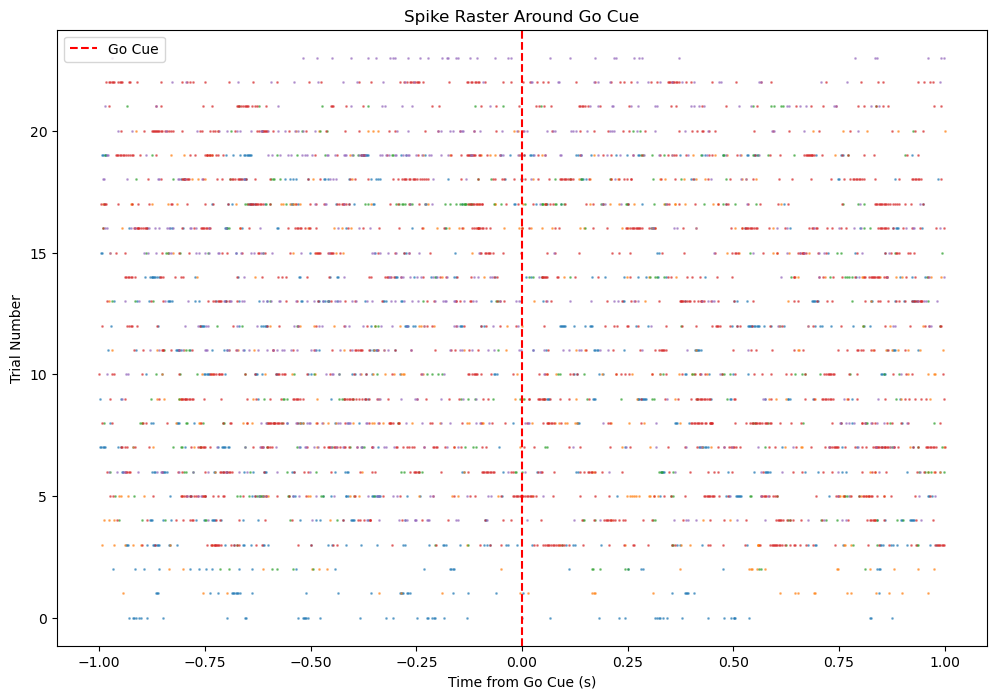

In [6]:
# Get spikes and trial events for a subset of trials
n_trials_to_plot = 20
trial_start_times = trials["start_time"][:n_trials_to_plot]
go_cue_times = trials["gocuettl"][:n_trials_to_plot]

# Select a few units with good firing rates
unit_indices = np.argsort(firing_rates)[-5:]  # Get 5 units with highest firing rates
plt.figure(figsize=(12, 8))

for i, unit_idx in enumerate(unit_indices):
    spike_times = units["spike_times"][unit_idx]
    
    # Plot spikes relative to trial start
    trial_spikes = []
    trial_numbers = []
    
    for trial_num, (start_time, go_time) in enumerate(zip(trial_start_times, go_cue_times)):
        # Get spikes in 2-second window around go cue
        mask = (spike_times >= go_time - 1) & (spike_times <= go_time + 1)
        trial_spikes.extend(spike_times[mask] - go_time)
        trial_numbers.extend([trial_num] * np.sum(mask))
    
    plt.scatter(trial_spikes, np.array(trial_numbers) + i, s=1, alpha=0.5)

plt.axvline(x=0, color='r', linestyle='--', label='Go Cue')
plt.title('Spike Raster Around Go Cue')
plt.xlabel('Time from Go Cue (s)')
plt.ylabel('Trial Number')
plt.legend()
plt.show()

## Next Steps for Analysis

This notebook demonstrates basic exploration of the dataset. Further analyses could include:

1. Detailed behavioral analysis:
   - Movement trajectories during navigation
   - Response time patterns
   - Error patterns based on target location

2. Advanced neural analyses:
   - Population dynamics during navigation
   - Neural encoding of distance/direction
   - Task-related neural activity patterns

3. Neural-behavioral correlations:
   - Relationship between neural activity and task performance
   - Neural predictors of successful navigation